## Data Preparation

### read data

In [80]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, processing, and visualizing data
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from datetime import datetime as dt

# To make candlestick charts
from mplfinance.original_flavor import candlestick_ohlc
# import mplfinance as mpl
# To grab stock data
import yfinance as fyf
from pandas_datareader import data as pdr
fyf.pdr_override() # <-- Here is the fix

# For reading files
from os import listdir

In [65]:
# Import data
avanza_data = pd.read_csv('sample_data.csv', encoding='utf-8')

# Translate to english
avanza_data.rename(columns={'Datum': 'Date', 
                            'Konto': 'Account',
                            'Typ av transaktion': 'Type',
                            'Värdepapper/beskrivning': 'Company',
                            'Antal': 'Amount',
                            'Kurs': 'Price',
                            'Belopp': 'TotalValueChange',
                            'Valuta': 'Currency'}, 
                   inplace=True)

avanza_data.replace({'Type' :
    {'Sälj': 'Sell',
     'Köp' : 'Buy',
     'Utdelning': 'Dividend',
     'Övrigt' : 'Other'}}, 
    inplace=True)

# Change date format and add column with numeric date values
avanza_data['Date'] = pd.to_datetime(avanza_data['Date'], format='%Y/%M/%d').dt.strftime('%Y-%M-%d')
avanza_data.insert(1, 'DateNum', mdates.date2num(avanza_data['Date']))

# Convert data types from string to numeric
avanza_data.replace('-', 'NaN', inplace=True)
avanza_data[['Price', 'TotalValueChange', 'Courtage']] = avanza_data[['Price', 'TotalValueChange', 'Courtage']].apply(pd.to_numeric, errors='coerce')
print(avanza_data)

          Date  DateNum  Account      Type      Company  Amount    Price  \
0   2021-04-23  18740.0  Nam ISK      Sell  NVIDIA Corp      -1  603.330   
1   2021-04-01  18718.0  Nam ISK  Dividend  NVIDIA Corp       1    1.394   
2   2021-02-09  18667.0  Nam ISK       Buy  NVIDIA Corp       1  574.190   
3   2021-03-11  18697.0  Nam ISK       Buy    Boeing Co       1  254.000   
4   2021-02-22  18680.0  Nam ISK       Buy    Boeing Co       1  219.390   
5   2021-02-03  18661.0  Nam ISK       Buy    Boeing Co       1  206.310   
6   2020-08-24  18498.0  Nam ISK      Sell    Boeing Co      -1  168.540   
7   2020-04-29  18381.0  Nam ISK       Buy    Boeing Co       1  135.700   
8   2021-05-14  18761.0  Nam ISK  Dividend    Apple Inc      11    1.837   
9   2021-02-12  18670.0  Nam ISK  Dividend    Apple Inc      11    1.703   
10  2021-02-01  18659.0  Nam ISK       Buy    Apple Inc       1  131.950   
11  2020-11-13  18579.0  Nam ISK  Dividend    Apple Inc      10    1.775   
12  2020-10-

In [66]:
transaction_data = avanza_data.loc[avanza_data['Company'] == 'Boeing Co']
print(transaction_data)

         Date  DateNum  Account  Type    Company  Amount   Price  \
3  2021-03-11  18697.0  Nam ISK   Buy  Boeing Co       1  254.00   
4  2021-02-22  18680.0  Nam ISK   Buy  Boeing Co       1  219.39   
5  2021-02-03  18661.0  Nam ISK   Buy  Boeing Co       1  206.31   
6  2020-08-24  18498.0  Nam ISK  Sell  Boeing Co      -1  168.54   
7  2020-04-29  18381.0  Nam ISK   Buy  Boeing Co       1  135.70   

   TotalValueChange  Courtage Currency          ISIN  
3           -2158.0       8.0      SEK  US0970231058  
4           -1829.0       8.0      SEK  US0970231058  
5           -1746.0       8.0      SEK  US0970231058  
6            1469.0       9.0      SEK  US0970231058  
7           -1349.0      10.0      SEK  US0970231058  


### read stock data

In [67]:
# Set label
stocks = ["BA"] # If you want to grab multiple stocks add more labels to this list

# Set start and end dates
start = datetime.datetime(2020, 1, 1)
end   = datetime.datetime(2021, 6, 30)

# Grab data
yahoo_data = pdr.get_data_yahoo(stocks, start = start, end = end)

# Remove space from column names
yahoo_data.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)

# Change to numeric index and add date columns
yahoo_data = yahoo_data.reset_index()
yahoo_data.insert(1, 'DateNum', mdates.date2num(yahoo_data['Date']))
print(yahoo_data)

[*********************100%***********************]  1 of 1 completed
          Date  DateNum        Open        High         Low       Close  \
0   2019-12-31  18261.0  325.410004  326.570007  323.320007  325.760010   
1   2020-01-02  18263.0  328.549988  333.350006  327.700012  333.320007   
2   2020-01-03  18264.0  330.630005  334.890015  330.299988  332.760010   
3   2020-01-06  18267.0  329.299988  334.859985  327.880005  333.739990   
4   2020-01-07  18268.0  334.260010  344.190002  330.709991  337.279999   
..         ...      ...         ...         ...         ...         ...   
372 2021-06-23  18801.0  244.800003  246.869995  243.169998  243.570007   
373 2021-06-24  18802.0  245.199997  250.740005  243.699997  250.570007   
374 2021-06-25  18803.0  250.750000  252.300003  248.250000  248.380005   
375 2021-06-28  18806.0  244.729996  245.080002  238.880005  239.960007   
376 2021-06-29  18807.0  243.740005  244.369995  235.660004  235.759995   

       AdjClose    Volume  
0 

In [73]:
# Merge transaction and Yahoo data frames
combined_data = yahoo_data.merge(transaction_data, on='DateNum', how='left')
combined_data.drop(columns='Date_y', inplace=True)
combined_data.rename(columns={'Date_x': 'Date'}, inplace=True)
print(combined_data)

          Date  DateNum        Open        High         Low       Close  \
0   2019-12-31  18261.0  325.410004  326.570007  323.320007  325.760010   
1   2020-01-02  18263.0  328.549988  333.350006  327.700012  333.320007   
2   2020-01-03  18264.0  330.630005  334.890015  330.299988  332.760010   
3   2020-01-06  18267.0  329.299988  334.859985  327.880005  333.739990   
4   2020-01-07  18268.0  334.260010  344.190002  330.709991  337.279999   
..         ...      ...         ...         ...         ...         ...   
372 2021-06-23  18801.0  244.800003  246.869995  243.169998  243.570007   
373 2021-06-24  18802.0  245.199997  250.740005  243.699997  250.570007   
374 2021-06-25  18803.0  250.750000  252.300003  248.250000  248.380005   
375 2021-06-28  18806.0  244.729996  245.080002  238.880005  239.960007   
376 2021-06-29  18807.0  243.740005  244.369995  235.660004  235.759995   

       AdjClose    Volume Account Type Company  Amount  Price  \
0    323.833313   4958800     NaN 

## Visualization

In [82]:
###############################################################################
#              4a. Visualize Data: Prepare data for Candlestick Chart         #
###############################################################################
# Get Open, High, Low, Close
ADI_candle = combined_data.iloc[:, [1, 2, 3, 4, 5]] # Analog Devices

# Get dates
# dates = combined_data['DateNum']

# Add dates column to OHLC DataFrames
# ADI_candle = pd.concat([dates, ADI_candle], axis = 1)

In [87]:
# Prepare our data
x_buy = []
y_buy = []
x_sell = []
y_sell = []
for (d,v,t) in zip(combined_data['DateNum'], combined_data['Price'], combined_data['Type']):
    if t == 'Buy':
#         x_buy.append(mdates.date2num(dt.strptime(d, '%Y/%m/%d')))
        x_buy.append(d)
        y_buy.append(float(v))
    if t == 'Sell':
#         x_sell.append(mdates.date2num(dt.strptime(d, '%Y/%m/%d')))
        x_sell.append(d)
        y_sell.append(float(v))

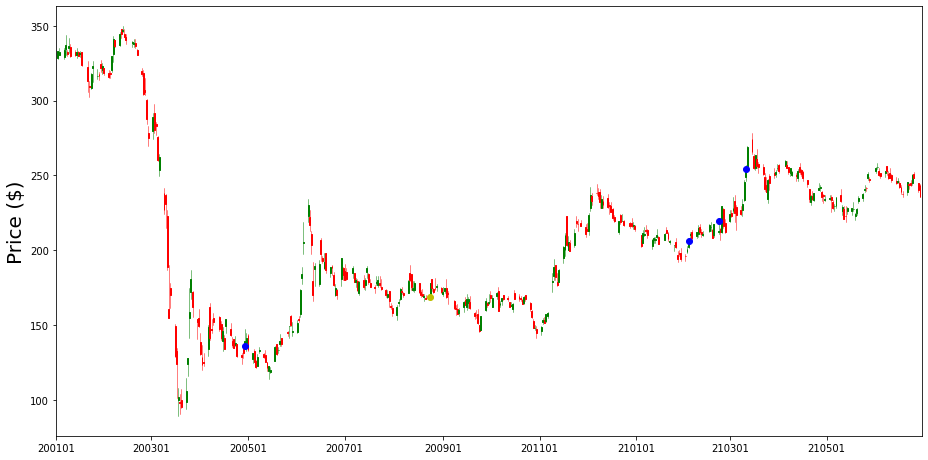

In [89]:
###############################################################################
#                 4b. Visualize Data: Make Candlestick Chart                  #
###############################################################################
# Define time interval to consider
start_date = datetime.date(2020, 1, 1) # Year-Month-Day
end_date   = datetime.date(2021, 6, 30)

# Create figure
fig, ax = plt.subplots(figsize=(13, 6.5))

# Plot ADI_OHLC data
candlestick_ohlc(ax, ADI_candle.values.tolist(), 
                 width=.6, 
                 colorup='green',
                 colordown='red')

# Plot our data
ax.plot(x_buy, y_buy, 'bo')
ax.plot(x_sell, y_sell, 'yo')

# Set x and y axis limits
ax.set_xlim([start_date, end_date])
# ax.set_ylim([60, 69])

# Set axis labels
ax.set_ylabel("Price ($)", fontsize = 20)

# Rotate tick labels
xlabels = ax.get_xticklabels()
# ax.set_xticklabels(xlabels, rotation = 45, fontsize = 14)

# Change x-axis tick label fromat
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y%m%d'))

# Send gridlines to back
ax.set_axisbelow(True)

# Tight layout
plt.tight_layout()


ref: https://medium.com/analytics-vidhya/stock-market-trends-b24203484e0f